[Episodio 0] Passi attaccati: pos=0, ang=0, entrambi=0


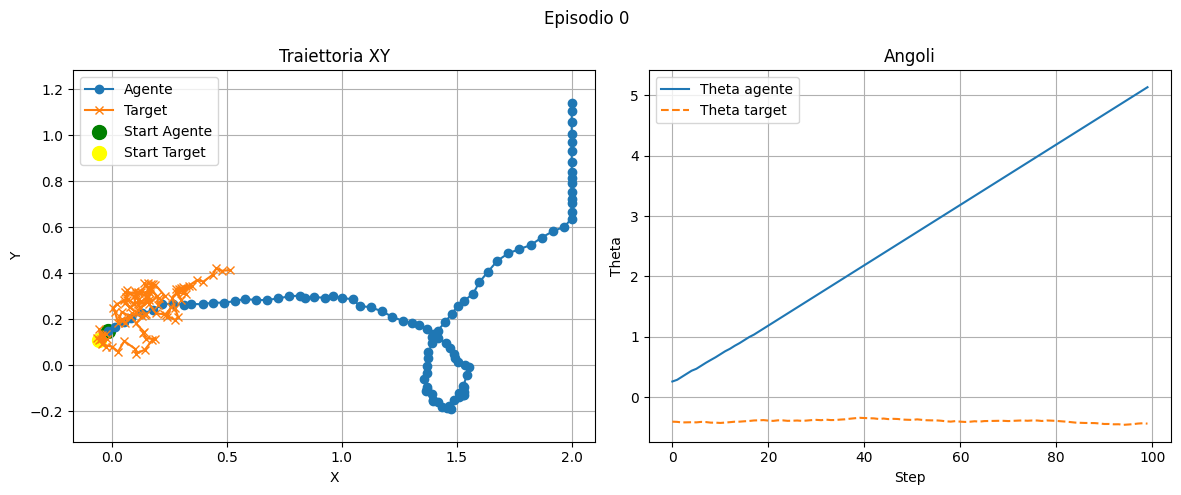

[Episodio 1] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 2] Passi attaccati: pos=1, ang=1, entrambi=0
[Episodio 3] Passi attaccati: pos=0, ang=1, entrambi=0
[Episodio 4] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 5] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 6] Passi attaccati: pos=0, ang=1, entrambi=0
[Episodio 7] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 8] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 9] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 10] Passi attaccati: pos=0, ang=1, entrambi=0
[Episodio 11] Passi attaccati: pos=0, ang=1, entrambi=0
[Episodio 12] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 13] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 14] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 15] Passi attaccati: pos=0, ang=1, entrambi=0
[Episodio 16] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 17] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 18] Passi attaccati: pos=0, ang=1, entrambi=0
[

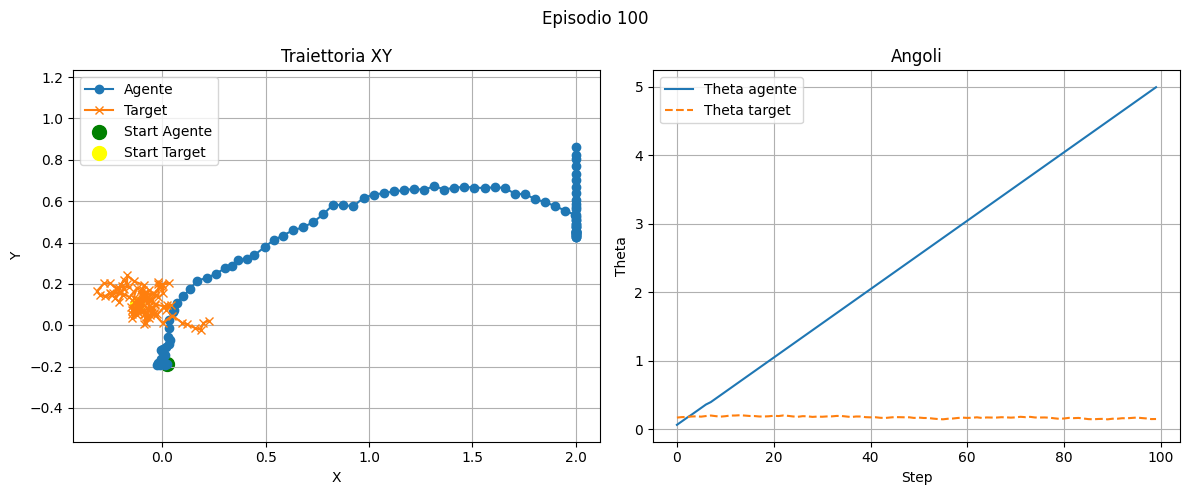

[Episodio 101] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 102] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 103] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 104] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 105] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 106] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 107] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 108] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 109] Passi attaccati: pos=0, ang=1, entrambi=0
[Episodio 110] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 111] Passi attaccati: pos=1, ang=1, entrambi=0
[Episodio 112] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 113] Passi attaccati: pos=0, ang=1, entrambi=0
[Episodio 114] Passi attaccati: pos=0, ang=1, entrambi=0
[Episodio 115] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 116] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 117] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 118] Passi attaccati:

KeyboardInterrupt: 

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from rototransl_env import TrackingEnv
from gail_transl import GaussianPolicy

def load_gail_policy(path="IL/gail_policy.pth"):
    model = GaussianPolicy(obs_dim=6, act_dim=3)
    model.load_state_dict(torch.load(path, map_location=torch.device("cpu")))
    model.eval()
    return model

def test_gail_policy(model, num_episodes=1000, tolerance_transl=0.02, tolerance_rot=0.01):
    env = TrackingEnv()
    
    total_attached = 0
    total_attached_transl = 0
    total_attached_rot = 0
    final_distances = []
    final_angle_errors = []

    for ep in range(num_episodes):
        state, _ = env.reset()
        state = torch.tensor(state, dtype=torch.float32)

        trajectory = []
        target_traj = []
        theta_traj = []
        theta_target_traj = []

        done = False
        total_attached_ep = 0
        total_attached_transl_ep = 0
        total_attached_rot_ep = 0

        while not done:
            trajectory.append(state[:2].numpy())
            target_traj.append(state[3:5].numpy())
            theta_traj.append(state[2].item())
            theta_target_traj.append(state[5].item())

            obs = state.unsqueeze(0)
            with torch.no_grad():
                dist = model(obs)  # restituisce una distribuzione
                action = dist.sample().squeeze(0).numpy()

            action = np.clip(action, env.action_space.low, env.action_space.high)

            next_state, _, done, truncated, _, _ = env.step(action)
            next_state = torch.tensor(next_state, dtype=torch.float32)

            dist_transl = torch.norm(next_state[:2] - state[3:5])
            dist_rot = torch.abs(next_state[2] - state[5])

            if dist_transl < tolerance_transl:
                total_attached_transl_ep += 1
            if dist_rot < tolerance_rot:
                total_attached_rot_ep += 1
            if dist_transl < tolerance_transl and dist_rot < tolerance_rot:
                total_attached_ep += 1

            state = next_state
            done = truncated

        final_distances.append(dist_transl.item())
        final_angle_errors.append(dist_rot.item())
        total_attached += total_attached_ep
        total_attached_transl += total_attached_transl_ep
        total_attached_rot += total_attached_rot_ep

        print(f"[Episodio {ep}] Passi attaccati: pos={total_attached_transl_ep}, ang={total_attached_rot_ep}, entrambi={total_attached_ep}")
        if ep % 100 == 0:
            plot_trajectory(trajectory, target_traj, theta_traj, theta_target_traj, ep)

    env.close()

    print("\nRisultati aggregati:")
    print(f"Media passi attaccati (traslazione): {total_attached_transl / num_episodes:.2f}")
    print(f"Media passi attaccati (rotazione):    {total_attached_rot / num_episodes:.2f}")
    print(f"Media passi attaccati (entrambi):     {total_attached / num_episodes:.2f}")
    print(f"Distanza media finale:                {np.mean(final_distances):.4f}")
    print(f"Errore medio angolo finale:           {np.mean(final_angle_errors):.4f}")

def plot_trajectory(trajectory, target_traj, theta_traj, theta_target_traj, episode):
    trajectory = np.array(trajectory)
    target_traj = np.array(target_traj)
    theta_traj = np.array(theta_traj)
    theta_target_traj = np.array(theta_target_traj)

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    axs[0].plot(trajectory[:, 0], trajectory[:, 1], marker='o', label="Agente")
    axs[0].plot(target_traj[:, 0], target_traj[:, 1], marker='x', label="Target")
    axs[0].scatter(trajectory[0, 0], trajectory[0, 1], color='green', label='Start Agente', s=100)
    axs[0].scatter(target_traj[0, 0], target_traj[0, 1], color='yellow', label='Start Target', s=100)
    axs[0].set_title("Traiettoria XY")
    axs[0].set_xlabel("X")
    axs[0].set_ylabel("Y")
    axs[0].legend()
    axs[0].grid(True)
    axs[0].axis('equal')

    axs[1].plot(theta_traj, label="Theta agente")
    axs[1].plot(theta_target_traj, label="Theta target", linestyle='--')
    axs[1].set_title("Angoli")
    axs[1].set_xlabel("Step")
    axs[1].set_ylabel("Theta")
    axs[1].legend()
    axs[1].grid(True)

    plt.suptitle(f"Episodio {episode}")
    plt.tight_layout()
    plt.show()
    plt.close()

# --- MAIN ---
if __name__ == "__main__":
    policy = load_gail_policy("IL/gail_policy.pth")
    test_gail_policy(policy, num_episodes=1000)


[Episodio 0] Passi attaccati: pos=0, ang=5, entrambi=0


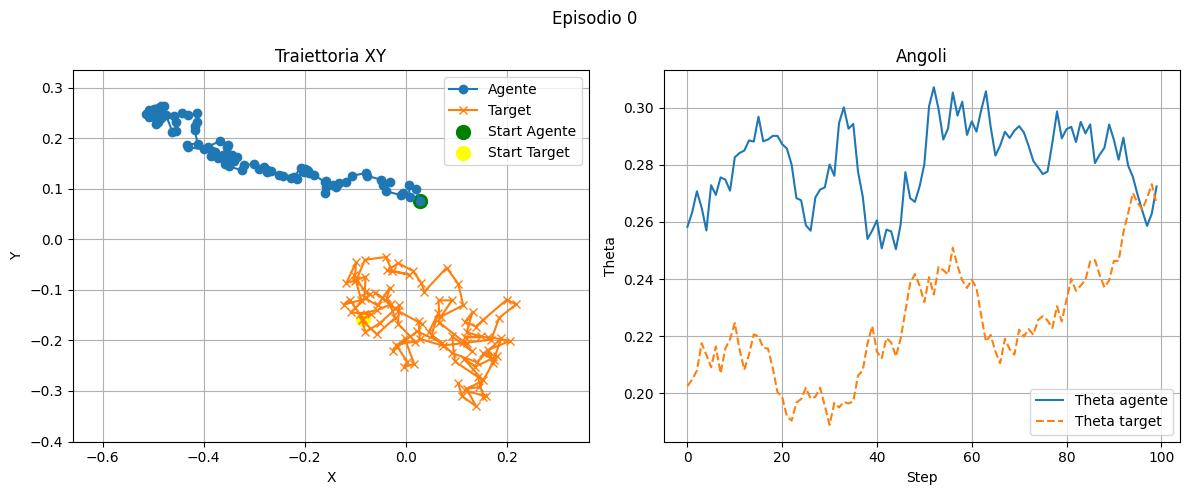

[Episodio 1] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 2] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 3] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 4] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 5] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 6] Passi attaccati: pos=0, ang=25, entrambi=0
[Episodio 7] Passi attaccati: pos=0, ang=22, entrambi=0
[Episodio 8] Passi attaccati: pos=1, ang=0, entrambi=0
[Episodio 9] Passi attaccati: pos=1, ang=0, entrambi=0
[Episodio 10] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 11] Passi attaccati: pos=0, ang=13, entrambi=0
[Episodio 12] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 13] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 14] Passi attaccati: pos=0, ang=21, entrambi=0
[Episodio 15] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 16] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 17] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 18] Passi attaccati: pos=0, ang=0, entrambi

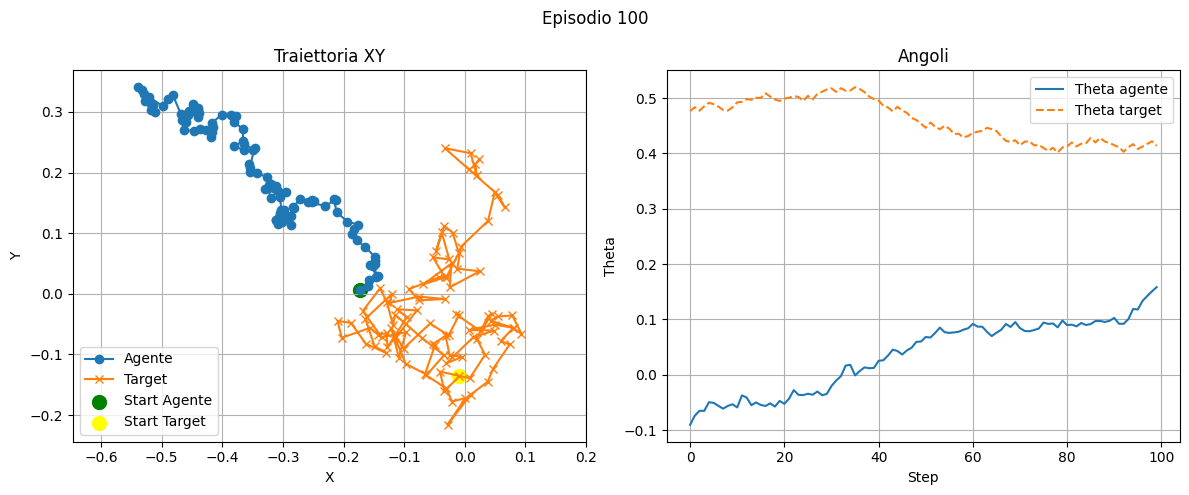

[Episodio 101] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 102] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 103] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 104] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 105] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 106] Passi attaccati: pos=0, ang=4, entrambi=0
[Episodio 107] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 108] Passi attaccati: pos=0, ang=15, entrambi=0
[Episodio 109] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 110] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 111] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 112] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 113] Passi attaccati: pos=2, ang=0, entrambi=0
[Episodio 114] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 115] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 116] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 117] Passi attaccati: pos=2, ang=0, entrambi=0
[Episodio 118] Passi attaccati

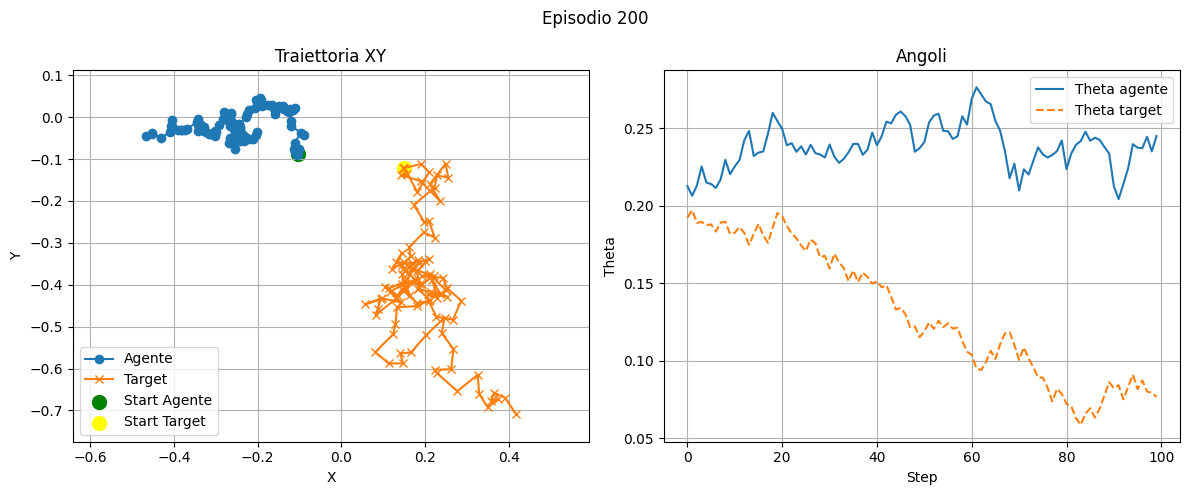

[Episodio 201] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 202] Passi attaccati: pos=2, ang=0, entrambi=0
[Episodio 203] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 204] Passi attaccati: pos=1, ang=0, entrambi=0
[Episodio 205] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 206] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 207] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 208] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 209] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 210] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 211] Passi attaccati: pos=0, ang=10, entrambi=0
[Episodio 212] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 213] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 214] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 215] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 216] Passi attaccati: pos=0, ang=4, entrambi=0
[Episodio 217] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 218] Passi attaccati

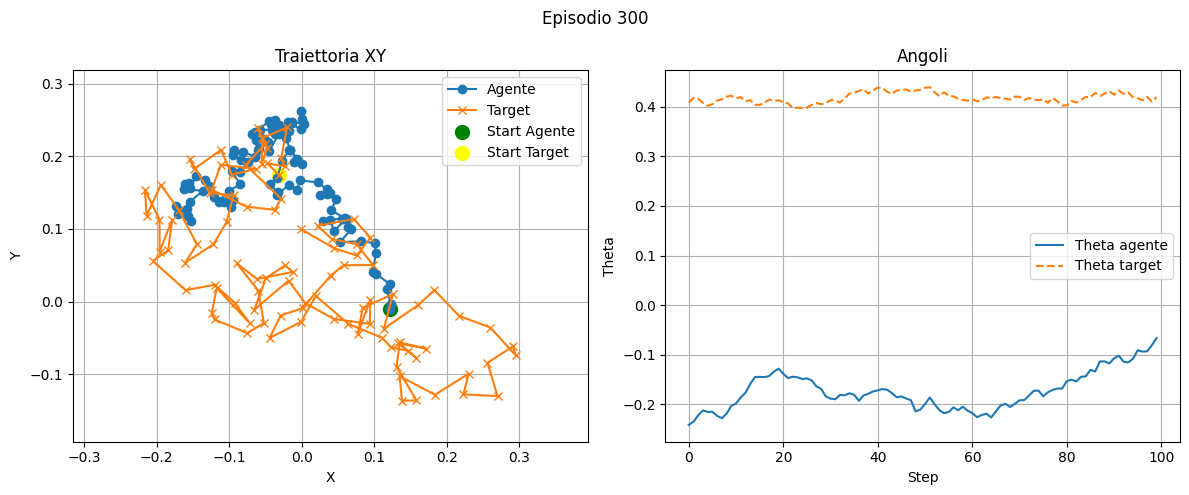

[Episodio 301] Passi attaccati: pos=2, ang=0, entrambi=0
[Episodio 302] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 303] Passi attaccati: pos=2, ang=0, entrambi=0
[Episodio 304] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 305] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 306] Passi attaccati: pos=1, ang=0, entrambi=0
[Episodio 307] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 308] Passi attaccati: pos=1, ang=1, entrambi=0
[Episodio 309] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 310] Passi attaccati: pos=0, ang=8, entrambi=0
[Episodio 311] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 312] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 313] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 314] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 315] Passi attaccati: pos=5, ang=0, entrambi=0
[Episodio 316] Passi attaccati: pos=1, ang=0, entrambi=0
[Episodio 317] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 318] Passi attaccati:

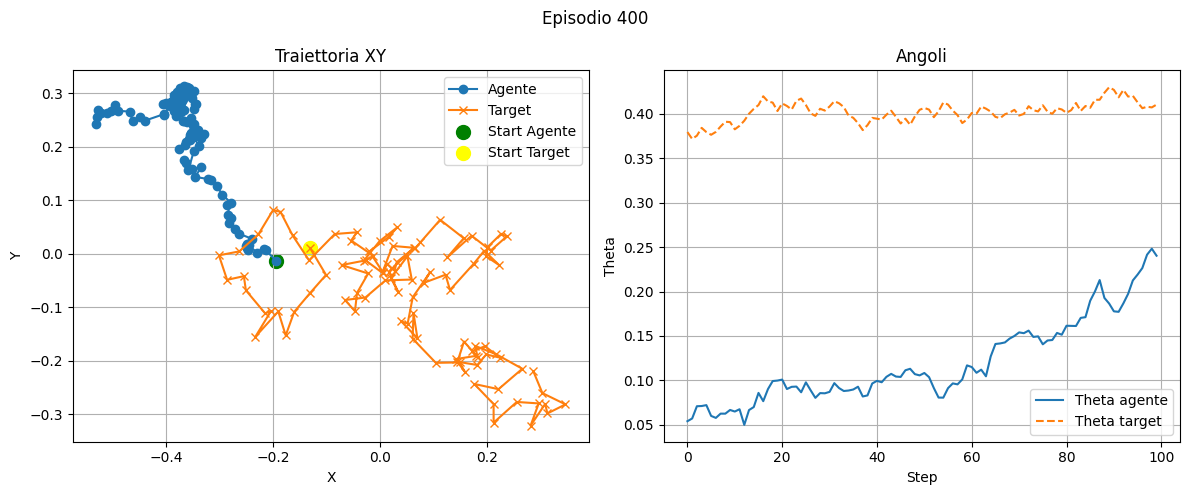

[Episodio 401] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 402] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 403] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 404] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 405] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 406] Passi attaccati: pos=1, ang=0, entrambi=0
[Episodio 407] Passi attaccati: pos=1, ang=0, entrambi=0
[Episodio 408] Passi attaccati: pos=0, ang=4, entrambi=0
[Episodio 409] Passi attaccati: pos=1, ang=0, entrambi=0
[Episodio 410] Passi attaccati: pos=0, ang=7, entrambi=0
[Episodio 411] Passi attaccati: pos=1, ang=18, entrambi=0
[Episodio 412] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 413] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 414] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 415] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 416] Passi attaccati: pos=1, ang=0, entrambi=0
[Episodio 417] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 418] Passi attaccati

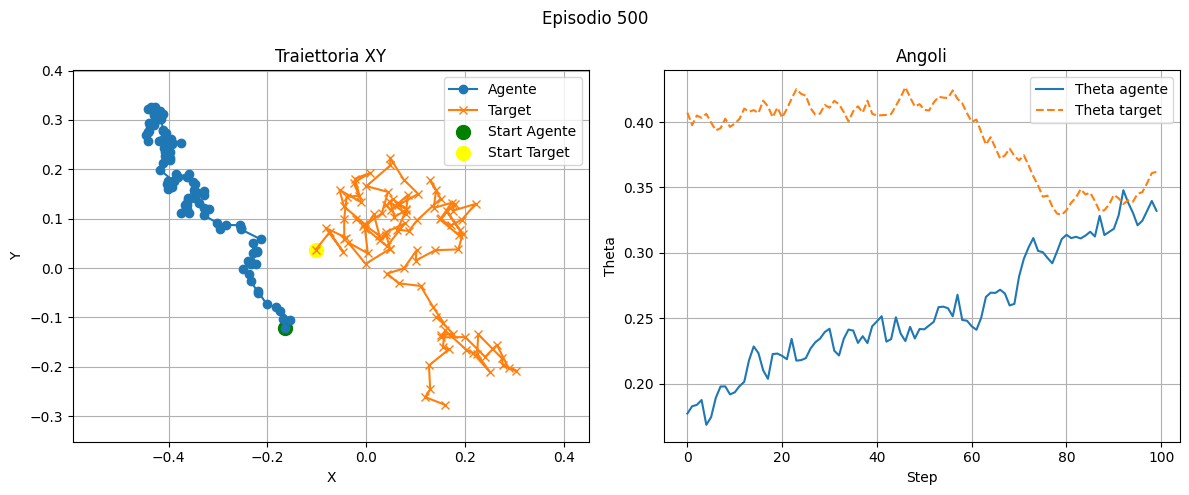

[Episodio 501] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 502] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 503] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 504] Passi attaccati: pos=0, ang=13, entrambi=0
[Episodio 505] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 506] Passi attaccati: pos=0, ang=11, entrambi=0
[Episodio 507] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 508] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 509] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 510] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 511] Passi attaccati: pos=0, ang=9, entrambi=0
[Episodio 512] Passi attaccati: pos=2, ang=29, entrambi=0
[Episodio 513] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 514] Passi attaccati: pos=1, ang=1, entrambi=0
[Episodio 515] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 516] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 517] Passi attaccati: pos=0, ang=9, entrambi=0
[Episodio 518] Passi attacca

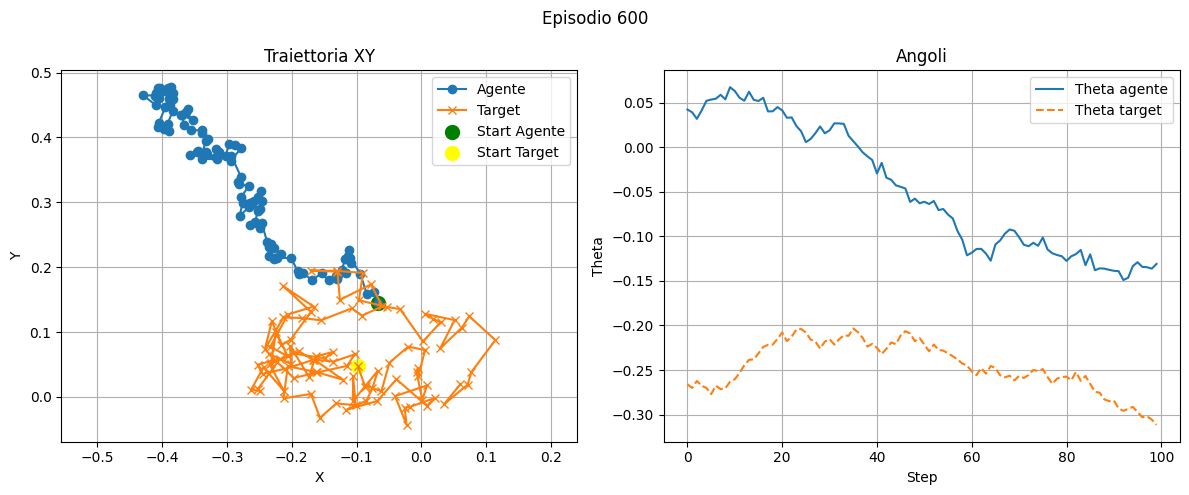

[Episodio 601] Passi attaccati: pos=1, ang=0, entrambi=0
[Episodio 602] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 603] Passi attaccati: pos=1, ang=0, entrambi=0
[Episodio 604] Passi attaccati: pos=1, ang=0, entrambi=0
[Episodio 605] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 606] Passi attaccati: pos=0, ang=11, entrambi=0
[Episodio 607] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 608] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 609] Passi attaccati: pos=1, ang=0, entrambi=0
[Episodio 610] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 611] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 612] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 613] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 614] Passi attaccati: pos=1, ang=0, entrambi=0
[Episodio 615] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 616] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 617] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 618] Passi attaccati

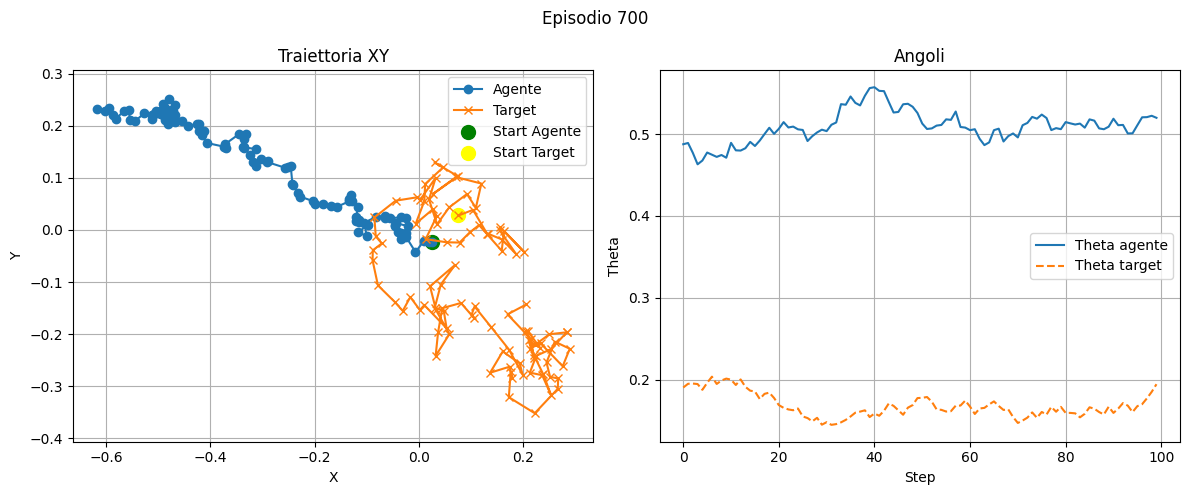

[Episodio 701] Passi attaccati: pos=0, ang=4, entrambi=0
[Episodio 702] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 703] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 704] Passi attaccati: pos=1, ang=0, entrambi=0
[Episodio 705] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 706] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 707] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 708] Passi attaccati: pos=0, ang=2, entrambi=0
[Episodio 709] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 710] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 711] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 712] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 713] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 714] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 715] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 716] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 717] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 718] Passi attaccati:

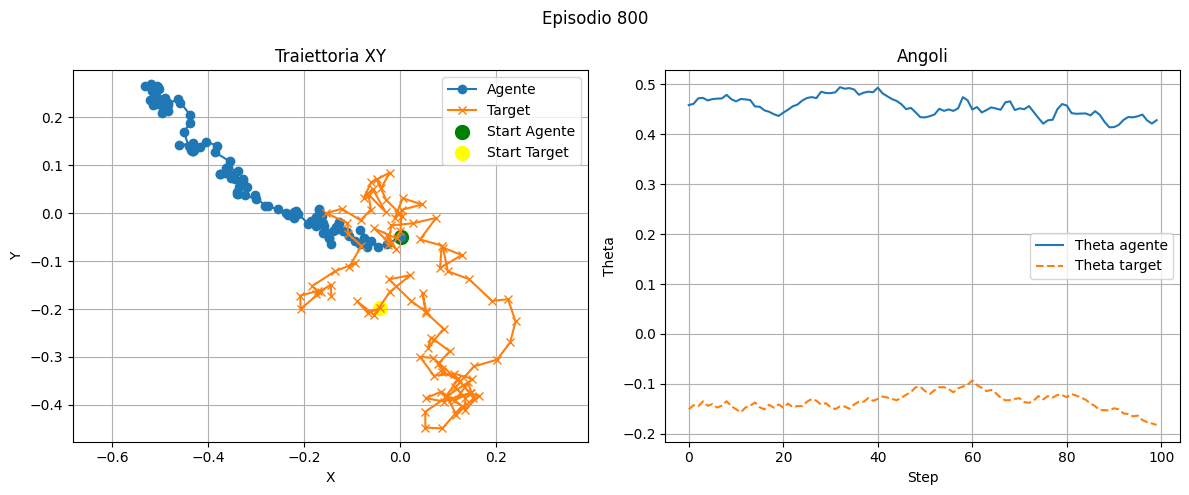

[Episodio 801] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 802] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 803] Passi attaccati: pos=0, ang=8, entrambi=0
[Episodio 804] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 805] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 806] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 807] Passi attaccati: pos=0, ang=2, entrambi=0
[Episodio 808] Passi attaccati: pos=5, ang=0, entrambi=0
[Episodio 809] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 810] Passi attaccati: pos=6, ang=0, entrambi=0
[Episodio 811] Passi attaccati: pos=0, ang=31, entrambi=0
[Episodio 812] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 813] Passi attaccati: pos=2, ang=5, entrambi=0
[Episodio 814] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 815] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 816] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 817] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 818] Passi attaccati

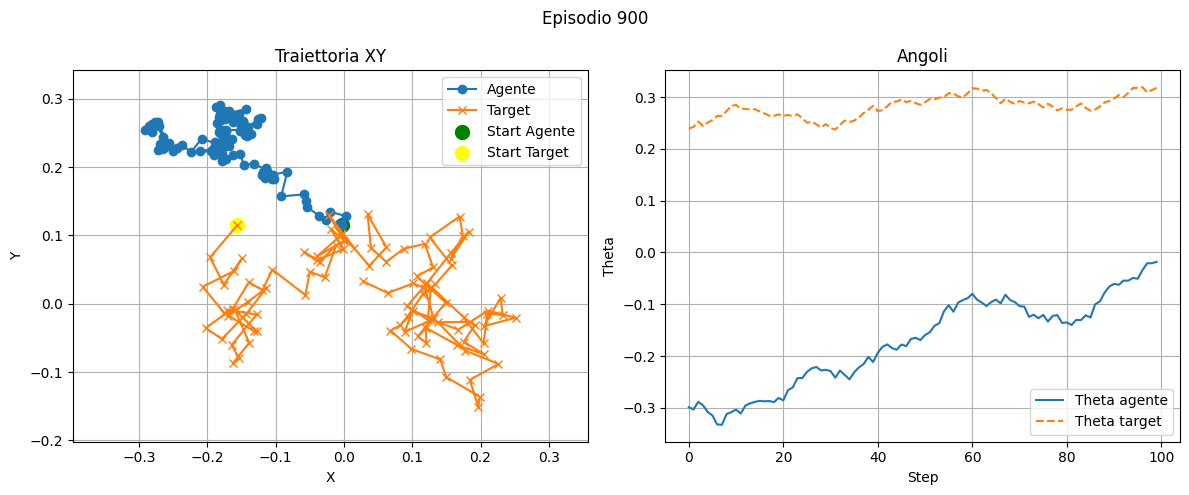

[Episodio 901] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 902] Passi attaccati: pos=0, ang=3, entrambi=0
[Episodio 903] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 904] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 905] Passi attaccati: pos=3, ang=0, entrambi=0
[Episodio 906] Passi attaccati: pos=0, ang=12, entrambi=0
[Episodio 907] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 908] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 909] Passi attaccati: pos=0, ang=11, entrambi=0
[Episodio 910] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 911] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 912] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 913] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 914] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 915] Passi attaccati: pos=1, ang=0, entrambi=0
[Episodio 916] Passi attaccati: pos=0, ang=16, entrambi=0
[Episodio 917] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 918] Passi attacca

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from rototransl_env import TrackingEnv
from gail_transl import GaussianPolicy_transl
from gail_rot import GaussianPolicy_rot

def load_policies(path_transl="IL/bc_policy_transl.pth", path_rot="IL/bc_policy_rot.pth"):
    model_transl = GaussianPolicy_transl()  # [x, y, x_t, y_t] -> [dx, dy]
    model_rot = GaussianPolicy_rot()     # [theta, theta_t] -> [dtheta]
    model_transl.load_state_dict(torch.load(path_transl, map_location=torch.device("cpu")))
    model_rot.load_state_dict(torch.load(path_rot, map_location=torch.device("cpu")))
    model_transl.eval()
    model_rot.eval()
    return model_transl, model_rot

def test_bc_dual_policy(model_transl, model_rot, num_episodes=1000, tolerance_transl=0.02, tolerance_rot=0.01):
    env = TrackingEnv()

    total_attached = 0
    total_attached_transl = 0
    total_attached_rot = 0
    final_distances = []
    final_angle_errors = []

    for ep in range(num_episodes):
        state, _ = env.reset()
        state = torch.tensor(state, dtype=torch.float32)

        trajectory = []
        target_traj = []
        theta_traj = []
        theta_target_traj = []

        done = False
        total_attached_ep = 0
        total_attached_transl_ep = 0
        total_attached_rot_ep = 0

        while not done:
            trajectory.append(state[:2].numpy())
            target_traj.append(state[3:5].numpy())
            theta_traj.append(state[2].item())
            theta_target_traj.append(state[5].item())

            # Separa osservazioni
            obs_transl = torch.cat([state[:2], state[3:5]]).unsqueeze(0)  # [x, y, x_t, y_t]
            obs_rot = torch.stack([state[2], state[5]]).unsqueeze(0)      # [theta, theta_t]

            with torch.no_grad():
                dist_transl = model_transl(obs_transl)
                action_transl = dist_transl.sample().squeeze(0)
                dist_rot = model_rot(obs_rot)
                action_rot = dist_rot.sample().squeeze(0)

            # with torch.no_grad():
            #     action_transl = model_transl(obs_transl).squeeze()
            #     action_rot = model_rot(obs_rot).squeeze()

            action = torch.cat([action_transl, action_rot], dim=0).numpy()
            action = np.clip(action, env.action_space.low, env.action_space.high)

            next_state, _, done, truncated, _, _ = env.step(action)
            next_state = torch.tensor(next_state, dtype=torch.float32)

            dist_transl = torch.norm(next_state[:2] - state[3:5])
            dist_rot = torch.abs(next_state[2] - state[5])

            if dist_transl < tolerance_transl:
                total_attached_transl_ep += 1
            if dist_rot < tolerance_rot:
                total_attached_rot_ep += 1
            if dist_transl < tolerance_transl and dist_rot < tolerance_rot:
                total_attached_ep += 1

            state = next_state
            done = truncated

        final_distances.append(dist_transl.item())
        final_angle_errors.append(dist_rot.item())
        total_attached += total_attached_ep
        total_attached_transl += total_attached_transl_ep
        total_attached_rot += total_attached_rot_ep

        print(f"[Episodio {ep}] Passi attaccati: pos={total_attached_transl_ep}, ang={total_attached_rot_ep}, entrambi={total_attached_ep}")
        if ep % 1 == 0:
            plot_trajectory(trajectory, target_traj, theta_traj, theta_target_traj, ep)

    env.close()

    print("\nRisultati aggregati:")
    print(f"Media passi attaccati (traslazione): {total_attached_transl / num_episodes:.2f}")
    print(f"Media passi attaccati (rotazione):    {total_attached_rot / num_episodes:.2f}")
    print(f"Media passi attaccati (entrambi):     {total_attached / num_episodes:.2f}")
    print(f"Distanza media finale:                {np.mean(final_distances):.4f}")
    print(f"Errore medio angolo finale:           {np.mean(final_angle_errors):.4f}")

def plot_trajectory(trajectory, target_traj, theta_traj, theta_target_traj, episode):
    trajectory = np.array(trajectory)
    target_traj = np.array(target_traj)
    theta_traj = np.array(theta_traj)
    theta_target_traj = np.array(theta_target_traj)

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    axs[0].plot(trajectory[:, 0], trajectory[:, 1], marker='o', label="Agente")
    axs[0].plot(target_traj[:, 0], target_traj[:, 1], marker='x', label="Target")
    axs[0].scatter(trajectory[0, 0], trajectory[0, 1], color='green', label='Start Agente', s=100)
    axs[0].scatter(target_traj[0, 0], target_traj[0, 1], color='yellow', label='Start Target', s=100)
    axs[0].set_title("Traiettoria XY")
    axs[0].set_xlabel("X")
    axs[0].set_ylabel("Y")
    axs[0].legend()
    axs[0].grid(True)
    axs[0].axis('equal')

    axs[1].plot(theta_traj, label="Theta agente")
    axs[1].plot(theta_target_traj, label="Theta target", linestyle='--')
    axs[1].set_title("Angoli")
    axs[1].set_xlabel("Step")
    axs[1].set_ylabel("Theta")
    axs[1].legend()
    axs[1].grid(True)

    plt.suptitle(f"Episodio {episode}")
    plt.tight_layout()
    plt.show()
    plt.close()

# --- MAIN ---
if __name__ == "__main__":
    policy_transl, policy_rot = load_policies("IL/gail_policy_transl.pth", "IL/gail_policy_rot.pth")
    test_bc_dual_policy(policy_transl, policy_rot, num_episodes=5)
